In [1]:
import librosa
import librosa.display
from scipy import signal
import numpy as np
from glob import glob
import os
import sys
import time
import random
from random import shuffle
from tqdm import tqdm
from tqdm import tnrange, tqdm_notebook
import pickle as pkl
import joblib
import matplotlib.pyplot as plt
%matplotlib inline

N_FFT = 1024
HOP_LENGTH = 256 
SAMPLING_RATE = 16000
MELSPEC_BANDS = 128

sample_secs = 2
num_samples = int(sample_secs * SAMPLING_RATE)

# Function to read in an audio file and return a mel spectrogram
def get_melspec(filepath_or_audio, hop_length=HOP_LENGTH, n_mels=MELSPEC_BANDS, n_samples=None, sample_secs=None):

    y_tmp = np.zeros(n_samples)
    
    # Load a little more than necessary as a buffer
    load_duration = None if sample_secs == None else 1.1 * sample_secs
    
    # Load audio file or take given input
    if type(filepath_or_audio)==str:
        y, sr = librosa.core.load(filepath_or_audio, sr = SAMPLING_RATE, mono=True, duration=load_duration)
    else:
        y = filepath_or_audio
        sr = SAMPLING_RATE
    
    # Truncate or pad
    if n_samples:
        if len(y) >= n_samples:
            y_tmp = y[:n_samples]
            lentgh_ratio = 1.0
        else:
            y_tmp[:len(y)] = y
            lentgh_ratio = len(y)/n_samples
    else:
        y_tmp = y
        length_ratio = 1.0
        
    # sfft -> mel conversion
    melspec = librosa.feature.melspectrogram(y=y_tmp, sr=sr,
                n_fft=N_FFT, hop_length=hop_length, n_mels=n_mels)
    S = librosa.power_to_db(melspec, np.max) 
        
    return S, lentgh_ratio

(128, 126)


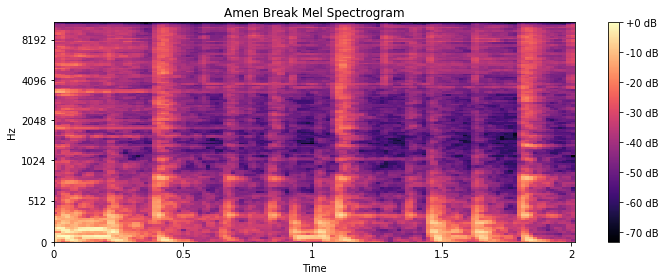

In [2]:
test_file = '/Volumes/SAMSUNG_HDD/SAMPLES/AMEN 001.aif'
# test_file = '/Users/Shared/Maschine 2 Library/Samples/Instruments/Wind/Wodden Flute Samples/Wodden Flute A2.wav'
spec, _ = get_melspec(test_file, n_samples=num_samples)
print(spec.shape)

plt.figure(figsize=(10, 4))
librosa.display.specshow(spec, sr=SAMPLING_RATE, y_axis='mel', x_axis='time', hop_length=HOP_LENGTH)
plt.colorbar(format='%+2.0f dB')
plt.title('Amen Break Mel Spectrogram')
plt.tight_layout()

In [4]:
_inv_mel_basis = None

def inv_melspectrogram(melspectrogram):
    S = _mel_to_linear(_db_to_amp(_denormalize(melspectrogram)))  # Convert back to linear
    return _inv_preemphasis(_griffin_lim(S ** 1.5))  # Reconstruct phase

def _mel_to_linear(mel_spectrogram):
    global _inv_mel_basis
    if _inv_mel_basis is None:
        _inv_mel_basis = np.linalg.pinv(_build_mel_basis())
    return np.maximum(1e-10, np.dot(_inv_mel_basis, mel_spectrogram))

def _db_to_amp(x):
    return np.power(10.0, x * 0.05)

def _preemphasis(x):
    return signal.lfilter([1, -hparams.preemphasis], [1], x)

def _inv_preemphasis(x):
    return signal.lfilter([1], [1, -hparams.preemphasis], x)

def _denormalize(S):
    return (np.clip(S, 0, 1) * -80.0) + 80.0

def inv_magphase(mag, phase_angle):
  phase = np.cos(phase_angle) + 1.j * np.sin(phase_angle)
  return mag * phase

def _build_mel_basis():
    n_fft = N_FFT
    return librosa.filters.mel(SAMPLING_RATE, n_fft, n_mels=MELSPEC_BANDS)

def griffin_lim(mag, phase_angle, n_fft, hop, num_iters):
    """Iterative algorithm for phase retrival from a magnitude spectrogram.

    Args:
    mag: Magnitude spectrogram.
    phase_angle: Initial condition for phase.
    n_fft: Size of the FFT.
    hop: Stride of FFT. Defaults to n_fft/2.
    num_iters: Griffin-Lim iterations to perform.

    Returns:
    audio: 1-D array of float32 sound samples.
    """
#     mag=inv_melspectrogram(mag)
    mag = _mel_to_linear(_db_to_amp(mag))
    
    fft_config = dict(n_fft=n_fft, win_length=n_fft, hop_length=hop, center=True)
    ifft_config = dict(win_length=n_fft, hop_length=hop, center=True)
    complex_specgram = inv_magphase(mag, phase_angle)
    for i in range(num_iters):
        audio = librosa.istft(complex_specgram, **ifft_config)
        if i != num_iters - 1:
              complex_specgram = librosa.stft(audio, **fft_config)
              _, phase = librosa.magphase(complex_specgram)
              phase_angle = np.angle(phase)
              complex_specgram = inv_magphase(mag, phase_angle)
    return audio 

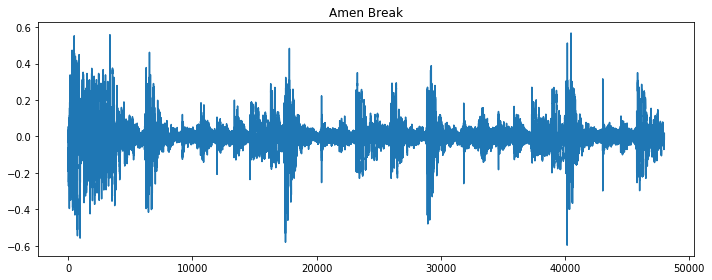

In [5]:
y, _ = librosa.core.load('/Volumes/SAMSUNG_HDD/SAMPLES/AMEN 001.aif', sr = SAMPLING_RATE, mono=True, duration=3.0)
plt.figure(figsize=(10, 4))
plt.plot(y)
# plt.colorbar(format='%+2.0f dB')
plt.title('Amen Break')
plt.tight_layout()

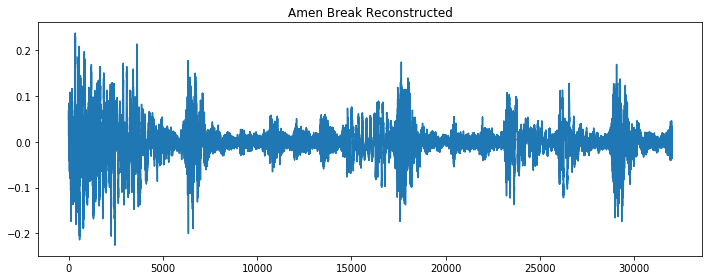

In [6]:
reconstructed = griffin_lim(spec, 0.1, N_FFT, HOP_LENGTH, 50)
plt.figure(figsize=(10, 4))
plt.plot(reconstructed)
# plt.colorbar(format='%+2.0f dB')
plt.title('Amen Break Reconstructed')
plt.tight_layout()
librosa.output.write_wav('recon.wav',reconstructed/np.max(reconstructed),sr=SAMPLING_RATE)

In [7]:
# Go through sample directories and find all audio files
sample_dirs = [
    '/Volumes/SAMSUNG_HDD/SAMPLES/',
    '/Users/Shared/Maschine 2 Library/Samples/',
    '/Users/Shared/Decoded Forms Library/Samples',
    '/Users/Shared/Prospect Haze Library/Samples',
    '/Users/Shared/Resonant Blaze Library/Samples'
]

audio_files = []

for root_dir in tqdm_notebook(sample_dirs):
    for dirName, subdirList, fileList in os.walk(root_dir, topdown=False):
        for fname in fileList:
            if os.path.splitext(fname)[1] in ['.wav', '.aiff']:
                audio_files.append('%s/%s' % (dirName,fname))    

In [8]:
len(audio_files)

61812

In [3]:
# class MacOSFile(object):

#     def __init__(self, f):
#         self.f = f

#     def __getattr__(self, item):
#         return getattr(self.f, item)

#     def read(self, n):
#         # print("reading total_bytes=%s" % n, flush=True)
#         if n >= (1 << 31):
#             buffer = bytearray(n)
#             idx = 0
#             while idx < n:
#                 batch_size = min(n - idx, 1 << 31 - 1)
#                 # print("reading bytes [%s,%s)..." % (idx, idx + batch_size), end="", flush=True)
#                 buffer[idx:idx + batch_size] = self.f.read(batch_size)
#                 # print("done.", flush=True)
#                 idx += batch_size
#             return buffer
#         return self.f.read(n)

#     def write(self, buffer):
#         n = len(buffer)
# #         print("writing total_bytes=%s..." % n, flush=True)
#         idx = 0
#         while idx < n:
#             batch_size = min(n - idx, 1 << 31 - 1)
# #             print("writing bytes [%s, %s)... " % (idx, idx + batch_size), end="", flush=True)
#             self.f.write(buffer[idx:idx + batch_size])
#             print("done.", flush=True)
#             idx += batch_size

# # If dataset exists, load, otherwise calcluate
# if os.path.isfile('dataset.pkl'):
#     print('Loading dataset.')
#     with open('dataset.pkl', 'rb') as handle:
#         dataset = pkl.load(MacOSFile(handle))
        
#     filenames = dataset['filenames']
#     melspecs = dataset['melspecs']
    
#     # Convert to array if still a list and overwrite old file
#     if type(melspecs) == list:
#         melspecs = np.array(melspecs)
        
#         # Store as pickle file
#         with open('dataset2.pkl', 'wb') as handle:
#             dataset = {'filenames' : filenames,
#                        'melspecs' : melspecs}
#             pkl.dump(dataset, MacOSFile(handle), protocol=pkl.HIGHEST_PROTOCOL)
        
# else:
#     print('Creating dataset.')
    
#     # Shuffle files
#     shuffle(audio_files)

#     # Calculate spectra
#     melspecs = []
#     filenames = []

#     for filename in tqdm_notebook(audio_files):
#         try:
#             spec = get_melspec(filename, n_samples=num_samples, sample_secs=sample_secs)
#             melspecs.append(spec)
#             filenames.append(filename)
#         except:
#             pass

#     # Convert spectra to single array
#     melspecs = np.array(melspecs)
        
#     # Store as pickle file
#     with open('dataset.pkl', 'wb') as handle:
#         dataset = {'filenames' : filenames,
#                    'melspecs' : melspecs}
#         pkl.dump(dataset, MacOSFile(handle), protocol=pkl.HIGHEST_PROTOCOL)

# If dataset exists, load, otherwise calcluate
if os.path.isfile('dataset.pkl'):
    print('Loading dataset.')
#     with open('dataset.pkl', 'rb') as handle:
#         dataset = pkl.load(handle)
        
    dataset = joblib.load('dataset.pkl')
    
    print('Dataset loaded.')
        
    filenames = dataset['filenames']
    melspecs = dataset['melspecs']
    actual_lengths = dataset['actual_lengths']
        
else:
    print('Creating dataset.')
    
    # Shuffle files
    shuffle(audio_files)

    # Calculate spectra
    melspecs = []
    filenames = []
    actual_lengths = []

    for filename in tqdm_notebook(audio_files):
        try:
            spec, length = get_melspec(filename, n_samples=num_samples, sample_secs=sample_secs)
            melspecs.append(spec)
            filenames.append(filename)
            actual_lengths.append(length)
        except:
            pass
        
    # Store as pickle file
    joblib.dump(dataset, 'dataset.pkl')
#     with open('dataset.pkl', 'wb') as handle:
#         dataset = {'filenames' : filenames,
#                    'melspecs' : melspecs,
#                    'actual_lengths' : actual_lengths}
#         pkl.dump(dataset, handle, protocol=pkl.HIGHEST_PROTOCOL)
    
    print('Dataset saved.')

# Convert spectra to array
melspecs = np.array(melspecs)

Loading dataset.
Dataset loaded.


In [5]:
filenames_short = filenames[0:500]
melspecs_short = melspecs[0:500]
actual_lengths_short = actual_lengths[0:500]

dataset_short = {'filenames' : filenames_short,
                   'melspecs' : melspecs_short,
                   'actual_lengths' : actual_lengths_short}

joblib.dump(dataset_short, 'dataset_small.pkl')

['dataset_small.pkl']

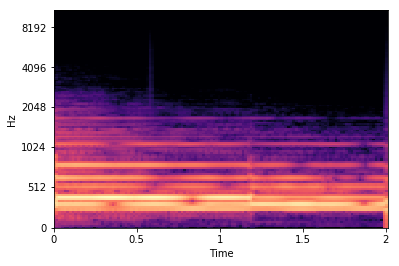

In [5]:
librosa.display.specshow(melspecs[-6], sr=SAMPLING_RATE, y_axis='mel', x_axis='time', hop_length=HOP_LENGTH)

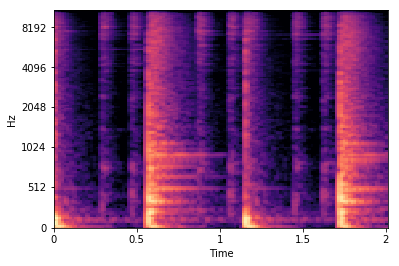

In [6]:
librosa.display.specshow(melspecs[1], sr=SAMPLING_RATE, y_axis='mel', x_axis='time', hop_length=HOP_LENGTH)

In [12]:
# del(dataset)
melspecs.shape

61476

In [ ]:
from shutil import copyfile

# Build dataset for Wavenet training
sample_length_sec = 3.0
num_samples_dataset = int(sample_length_sec * SAMPLING_RATE)

dataset_dir = '/Volumes/SAMSUNG_HDD/samples_spec_dataset/'

# Shuffle files
shuffle(audio_files)

counter = 0

for filename in tqdm_notebook(audio_files):
    try: 
        # Load audio file
        y, sr = librosa.core.load(filename, sr = SAMPLING_RATE, mono=True, duration=sample_length_sec)

        y_tmp = np.zeros(num_samples_dataset)

        # Truncate or pad
        if len(y) >= num_samples_dataset:
            y_tmp = y[:num_samples_dataset]
        else:
            y_tmp[:len(y)] = y

        # Calculate spectrum
        spec, _ = get_melspec(y_tmp, n_samples=num_samples_dataset)

        filename = os.path.splitext(os.path.split(filename)[1])[0]

        dataset_filename = dataset_dir + str(counter) + ' - ' + filename + '.wav'
        dataset_filename_spec = dataset_dir + str(counter) + ' - ' + filename + '.npy'

        # Write to file
        librosa.output.write_wav(dataset_filename, y_tmp, sr, norm=True)
        np.save(dataset_filename_spec,spec)

        counter += 1
    
    except:
        pass

In [7]:
emb = np.load('/Users/maxfrenzel/AI/Music/Sound Similarity/iaf5_64d_2/embeddings-6763/30 - Swell ResoCave.npy')
emb

array([-0.39696681, -0.3491319 ,  1.291283  , -0.7323511 ,  0.39709964,
       -0.47420633,  0.7624339 ,  0.05445062,  0.6581977 ,  0.20207132,
       -0.7031568 , -0.13762805, -0.377499  ,  0.20230293,  1.1168212 ,
        0.38403156, -0.68650436,  0.6669817 ,  0.13245764,  1.1474936 ,
        0.38760728,  1.6634676 , -0.7450712 ,  1.0858009 , -0.52709633,
       -0.5090164 ,  1.1113269 ,  0.44335133, -1.1333221 , -0.5574945 ,
       -0.3368964 , -0.08503474,  1.1055548 , -0.09287664, -1.1439621 ,
       -0.408082  , -0.29929674,  0.2932633 , -0.31196567, -0.53775334,
        0.82611305,  0.44779652, -0.03927908,  0.2925262 , -0.4800081 ,
        1.4818014 , -0.31431895, -0.85079145, -0.57529926, -0.24452683,
       -0.12684116, -1.1110451 , -0.00636625, -0.08722192,  2.3935452 ,
        0.06182185,  0.33970684, -0.12116817, -0.3956753 , -2.057557  ,
        0.0097957 , -0.07230616,  0.5852694 , -0.6235894 ], dtype=float32)

(128, 188)


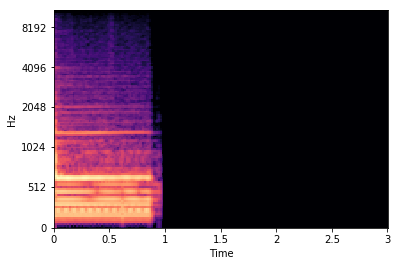

In [4]:
spec = np.load('/Volumes/SAMSUNG_HDD/samples_spec_dataset/1 - Chord Flake 1.npy')
print(spec.shape)
librosa.display.specshow(spec, sr=SAMPLING_RATE, y_axis='mel', x_axis='time', hop_length=HOP_LENGTH)

In [61]:
import tensorflow as tf

def create_variable(name, shape):
    '''Create a convolution filter variable with the specified name and shape,
    and initialize it using Xavier initialition.'''
    initializer = tf.contrib.layers.xavier_initializer_conv2d()
    variable = tf.Variable(initializer(shape=shape), name=name)
    return variable

def create_bias_variable(name, shape):
    '''Create a bias variable with the specified name and shape and initialize
    it to zero.'''
    initializer = tf.constant_initializer(value=0.0, dtype=tf.float32)
    return tf.Variable(initializer(shape=shape), name)

# def upsample(net, name, stride, mode='ZEROS'):
#     """
#     Imitate reverse operation of Max-Pooling by either placing original max values
#     into a fixed postion of upsampled cell:
#     [0.9] =>[[.9, 0],   (stride=2)
#            [ 0, 0]]
#     or copying the value into each cell:
#     [0.9] =>[[.9, .9],  (stride=2)
#            [ .9, .9]]
#     :param net: 4D input tensor with [batch_size, width, heights, channels] axis
#     :param stride:
#     :param mode: string 'ZEROS' or 'COPY' indicating which value to use for undefined cells
#     :return:  4D tensor of size [batch_size, width*stride, heights*stride, channels]
#     """
#     assert mode in ['COPY', 'ZEROS']
#     with tf.name_scope('Upsampling'):
#         net = _upsample_along_axis(net, 2, stride[1], mode=mode)
#         net = _upsample_along_axis(net, 1, stride[0], mode=mode)
#         return net


# def _upsample_along_axis(volume, axis, stride, mode='ZEROS'):
#     shape = volume.get_shape().as_list()

#     assert mode in ['COPY', 'ZEROS']
#     assert 0 <= axis < len(shape)

#     target_shape = shape[:]
#     target_shape[axis] *= stride
    
#     print(volume.dtype)
#     print(shape)

#     padding = tf.zeros(shape, dtype=volume.dtype) if mode == 'ZEROS' else volume
#     parts = [volume] + [padding for _ in range(stride - 1)]
#     volume = tf.concat(parts, min(axis+1, len(shape)-1))

#     volume = tf.reshape(volume, target_shape)
#     return volume

def upsample(value, name, factor=[2,2]):
    size = [int(value.shape[1] * factor[0]), int(value.shape[2] * factor[1])]
    with tf.name_scope(name):
        out = tf.image.resize_bilinear(value, size=size, align_corners=None, name=None)
        return out
    
def upsample2(value, name, output_shape):
    size = [int(output_shape[1]), int(output_shape[2])]
    with tf.name_scope(name):
        out = tf.image.resize_bilinear(value, size=size, align_corners=None, name=None)
        return out

def two_d_conv(value, filter_, pool_kernel=[2,2], name='two_d_conv'):
    
    out = tf.nn.conv2d(value, filter_, strides=[1,1,1,1], padding='SAME')
    out = tf.contrib.layers.max_pool2d(out, pool_kernel)
    
    return out

def two_d_deconv(value, filter_, deconv_shape, pool_kernel=[2,2], name='two_d_conv'):
    
    out = upsample2(value, 'unpool', deconv_shape)
    print(out)
    out = tf.nn.conv2d_transpose(out, filter_, output_shape=deconv_shape,strides=[1,1,1,1], padding='SAME')
    print(out)
    
    return out

        
class VAEModel(object):
    
    def __init__(self,
                 param,
                 activation=tf.nn.relu, 
                 activation_conv=tf.nn.elu, 
                 activation_nf=tf.nn.relu, 
                 encode=False):
        
        self.param = param
        self.activation = activation
        self.activation_conv = activation_conv
        self.activation_nf = activation_nf
        self.encode = encode
        self.layers_enc = len(param['conv_channels'])
        self.layers_dec = self.layers_enc
        self.conv_out_shape = [7,7]
        self.conv_out_units = self.conv_out_shape[0]*self.conv_out_shape[1]*param['conv_channels'][-1]
        self.cells_hidden = 512
        
        self.variables = self._create_variables()
        
    def _create_variables(self):
        '''This function creates all variables used by the network.
        This allows us to share them between multiple calls to the loss
        function and generation function.'''
        
        var = dict()

        with tf.variable_scope('VAE'):
            
            with tf.variable_scope("Encoder"):
                
                var['encoder_conv'] = list()
                with tf.variable_scope('conv_stack'):
                
                    for l in range(self.layers_enc):

                        with tf.variable_scope('layer{}'.format(l)):
                            current = dict()

                            if l == 0:
                                channels_in = 1
                            else:
                                channels_in = self.param['conv_channels'][l - 1]
                            channels_out = self.param['conv_channels'][l]

                            current['filter'] = create_variable("filter",
                                                [3, 3, channels_in, channels_out])
#                             current['bias'] = create_bias_variable("bias",
#                                               [channels_out])
                            var['encoder_conv'].append(current)
                            
                with tf.variable_scope('fully_connected'):
                    
                    layer = dict()
                    
                    layer['W_z0'] = create_variable("W_z0",
                            shape=[self.conv_out_units, self.cells_hidden])
                    layer['b_z0'] = create_bias_variable("b_z0",
                            shape=[1, self.cells_hidden])

                    layer['W_mu'] = create_variable("W_mu",
                            shape=[self.cells_hidden, self.param['dim_latent']])
                    layer['W_logvar'] = create_variable("W_logvar",
                            shape=[self.cells_hidden, self.param['dim_latent']])
                    layer['b_mu'] = create_bias_variable("b_mu",
                            shape=[1, self.param['dim_latent']])
                    layer['b_logvar'] = create_bias_variable("b_logvar",
                            shape=[1, self.param['dim_latent']])
                    
                    var['encoder_fc'] = layer
                    
            with tf.variable_scope("Decoder"):
                
                with tf.variable_scope('fully_connected'):
                    layer = dict()
                    
                    layer['W_z'] = create_variable("W_z",
                                   shape=[self.param['dim_latent'], self.conv_out_units])
                    layer['b_z'] = create_bias_variable("b_z",
                                   shape=[1, self.conv_out_units])
                    
                    var['decoder_fc'] = layer
                    
                var['decoder_deconv'] = list()
                with tf.variable_scope('deconv_stack'):
                    
                    for l in range(self.layers_enc):
                        with tf.variable_scope('layer{}'.format(l)):
                            current = dict()
                            
                            channels_in = self.param['conv_channels'][-1-l]
                            if l == self.layers_enc-1: 
                                channels_out = 1
                            else:
                                channels_out = self.param['conv_channels'][-l-2]

                            current['filter'] = create_variable("filter",
                                                [3, 3, channels_out, channels_in])
#                             current['bias'] = create_bias_variable("bias",
#                                                 [channels_out])
                            var['decoder_deconv'].append(current)
                            
        return var
    
    def _create_network(self, input_batch, keep_prob=1.0, encode=False):
        
        # Do encoder calculation
        encoder_hidden = input_batch
        for l in range(self.layers_enc):
            print(encoder_hidden)
            encoder_hidden = two_d_conv(encoder_hidden, self.variables['encoder_conv'][l]['filter'], 
                                        self.param['max_pooling'][l])
            encoder_hidden = self.activation_conv(encoder_hidden)
            
        print(encoder_hidden)
            
        encoder_hidden = tf.reshape(encoder_hidden, [-1,self.conv_out_units])
        
        print(encoder_hidden)
        
        # Additional non-linearity between encoder hidden state and prediction of mu_0,sigma_0
        mu_logvar_hidden = tf.nn.dropout(self.activation(tf.matmul(encoder_hidden, 
                                                                   self.variables['encoder_fc']['W_z0'])
                                                    + self.variables['encoder_fc']['b_z0']),
                                         keep_prob=keep_prob)
        
        print(mu_logvar_hidden)
        
        encoder_mu = tf.add(tf.matmul(mu_logvar_hidden, self.variables['encoder_fc']['W_mu']), 
                            self.variables['encoder_fc']['b_mu'], name='ZMu')
        encoder_logvar = tf.add(tf.matmul(mu_logvar_hidden, self.variables['encoder_fc']['W_logvar']), 
                                self.variables['encoder_fc']['b_logvar'], name='ZLogVar')
        
        print(encoder_mu)
        
        # Convert log variance into standard deviation
        encoder_std = tf.exp(0.5 * encoder_logvar)

        # Sample epsilon
        epsilon = tf.random_normal(tf.shape(encoder_std), name='epsilon')
        
        if encode:
            z0 = tf.identity(encoder_mu, name='LatentZ0')
        else:
            z0 = tf.identity(tf.add(encoder_mu, tf.multiply(encoder_std, epsilon),
                             name='LatentZ0'))
                             
        print(z0)
        
        # Fully connected
        decoder_hidden = tf.nn.dropout(self.activation(tf.matmul(z0, self.variables['decoder_fc']['W_z'])
                                                    + self.variables['decoder_fc']['b_z']),
                                         keep_prob=keep_prob)
        
        print(decoder_hidden)
        
        # Reshape
        decoder_hidden = tf.reshape(decoder_hidden, [-1,self.conv_out_shape[0],self.conv_out_shape[1], 
                                                     self.param['conv_channels'][-1]])
        
        for l in range(self.layers_enc):
            print(decoder_hidden)
            
#             if l == 0:
#                 pool_kernel = [1,1]
#             else:
            pool_kernel = self.param['max_pooling'][-1-l]
            decoder_hidden = two_d_deconv(decoder_hidden, self.variables['decoder_deconv'][l]['filter'], 
                                          self.param['deconv_shape'][l], pool_kernel)
            if l < self.layers_enc-1:
                decoder_hidden = self.activation_conv(decoder_hidden)
        
        decoder_output = tf.nn.sigmoid(decoder_hidden)
        
        print(decoder_output)
        
        return decoder_output, encoder_mu, encoder_logvar, encoder_std
        
    def loss(self,
             input_batch,
             name='vae'):
        
        with tf.name_scope(name): 
            
            output, encoder_mu, encoder_logvar, encoder_std = self._create_network(input_batch)
                
            loss_latent = tf.identity(-0.5 * tf.reduce_sum(1 + encoder_logvar
                                           - tf.square(encoder_mu) 
                                           - tf.square(encoder_std), 1),name='LossLatent')
        
            loss_reconstruction = tf.identity(-tf.reduce_sum(input_batch * tf.log(1e-10 + output)
                                 + (1-input_batch) * tf.log(1e-10 + 1 - output),
                                 1),name='LossReconstruction')

            loss = tf.reduce_mean(loss_reconstruction + loss_latent, name='Loss')
            
            return loss

In [51]:
import threading

def randomize_specs(specs):
    for k in range(specs.shape[0]):
        file_index = random.randint(0, (specs.shape[0] - 1))
        yield specs[file_index]

def return_spec(specs):

    randomized_specs = randomize_specs(specs)
    for spec in randomized_specs:
        
        # Convert from -80 to 0dB to range [0,1], and add channel dimension
        normalized_spec = np.expand_dims((spec+80.0)/80.0,2)
        yield normalized_spec

class SpectrogramReader(object):
    def __init__(self,
                 specs,
                 coord,
                 queue_size=32):
        
        self.specs = specs
        self.coord = coord
        self.threads = []
        self.spec_placeholder = tf.placeholder(dtype=tf.float32, shape=None)
        self.queue = tf.PaddingFIFOQueue(queue_size,
                                         ['float32'],
                                         shapes=[(128, 126, 1)])
        self.enqueue = self.queue.enqueue([self.spec_placeholder])
        
    def dequeue(self, num_elements):
        output = self.queue.dequeue_many(num_elements)
        return output
    
    def thread_main(self, sess):
        stop = False
        # Go through the dataset multiple times
        while not stop:
            iterator = return_spec(self.specs)
            for spec in iterator:
                if self.coord.should_stop():
                    stop = True
                    break
                
                sess.run(self.enqueue,
                         feed_dict={self.spec_placeholder: spec})

    def start_threads(self, sess, n_threads=1):
        for _ in range(n_threads):
            thread = threading.Thread(target=self.thread_main, args=(sess,))
            thread.daemon = True  # Thread will close when parent quits.
            thread.start()
            self.threads.append(thread)
        return self.threads

In [64]:
logdir='./log'
max_checkpoints=5
num_steps = 10000
checkpoint_every=500
batch_size = 64
tf.reset_default_graph()

def save(saver, sess, logdir, step):
    model_name = 'model.ckpt'
    checkpoint_path = os.path.join(logdir, model_name)
    print('Storing checkpoint to {} ...'.format(logdir), end="")
    sys.stdout.flush()

    if not os.path.exists(logdir):
        os.makedirs(logdir)

    saver.save(sess, checkpoint_path, global_step=step)
    print(' Done.')


def load(saver, sess, logdir):
    print("Trying to restore saved checkpoints from {} ...".format(logdir),
          end="")

    ckpt = tf.train.get_checkpoint_state(logdir)
    if ckpt:
        print("  Checkpoint found: {}".format(ckpt.model_checkpoint_path))
        global_step = int(ckpt.model_checkpoint_path
                          .split('/')[-1]
                          .split('-')[-1])
        print("  Global step was: {}".format(global_step))
        print("  Restoring...", end="")
        saver.restore(sess, ckpt.model_checkpoint_path)
        print(" Done.")
        return global_step
    else:
        print(" No checkpoint found.")
        return None

param = dict()
param['dim_latent'] = 64
param['conv_channels'] = [32,64,32,32]
param['max_pooling'] = [[4,4],[2,2],[2,4],[2,2]]
param['deconv_shape'] = [
    [-1, 15, 14, 32],
    [-1, 31, 31, 64],
    [-1, 63, 62, 32],
    [-1, 128, 126, 1]
]
learning_rate=1e3

# Create coordinator.
coord = tf.train.Coordinator()

with tf.name_scope('create_inputs'):
    
    reader = SpectrogramReader(melspecs,coord)
    spec_batch = reader.dequeue(batch_size)

# Create network.
net = VAEModel(param)

loss = net.loss(spec_batch)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                  epsilon=1e-4)
trainable = tf.trainable_variables()
for var in trainable:
    print(var)
optim = optimizer.minimize(loss, var_list=trainable)

# Set up logging for TensorBoard.
writer = tf.summary.FileWriter(logdir)
writer.add_graph(tf.get_default_graph())
run_metadata = tf.RunMetadata()
summaries = tf.summary.merge_all()

 # Set up session
sess = tf.Session(config=tf.ConfigProto(log_device_placement=False))
init = tf.global_variables_initializer()
sess.run(init)

# Saver for storing checkpoints of the model.
saver = tf.train.Saver(var_list=tf.trainable_variables(), max_to_keep=max_checkpoints)

try:
    saved_global_step = load(saver, sess, logdir)
    if saved_global_step is None:
        # The first training step will be saved_global_step + 1,
        # therefore we put -1 here for new or overwritten trainings.
        saved_global_step = -1

except:
    print("Something went wrong while restoring checkpoint. "
          "We will terminate training to avoid accidentally overwriting "
          "the previous model.")
    raise
    
threads = tf.train.start_queue_runners(sess=sess, coord=coord)
reader.start_threads(sess)
    
step = None
last_saved_step = saved_global_step    
try:
    for step in range(saved_global_step + 1, num_steps):
        start_time = time.time()
        
        summary, loss_value, _ = sess.run([summaries, loss, optim])

        writer.add_summary(summary, step)

        duration = time.time() - start_time
        print('step {:d} - loss = {:.3f}, ({:.3f} sec/step)'
              .format(step, loss_value, duration))

        if step % checkpoint_every == 0:
            save(saver, sess, logdir, step)
            last_saved_step = step

except KeyboardInterrupt:
    # Introduce a line break after ^C is displayed so save message
    # is on its own line.
    print()
finally:
    if step > last_saved_step:
        save(saver, sess, logdir, step)
    coord.request_stop()
    coord.join(threads)

Tensor("create_inputs/padding_fifo_queue_DequeueMany:0", shape=(64, 128, 126, 1), dtype=float32)
Tensor("vae_1/Elu:0", shape=(64, 63, 62, 32), dtype=float32)
Tensor("vae_1/Elu_1:0", shape=(64, 31, 31, 64), dtype=float32)
Tensor("vae_1/Elu_2:0", shape=(64, 15, 14, 32), dtype=float32)
Tensor("vae_1/Elu_3:0", shape=(64, 7, 7, 32), dtype=float32)
Tensor("vae_1/Reshape:0", shape=(64, 1568), dtype=float32)
Tensor("vae_1/Relu:0", shape=(64, 512), dtype=float32)
Tensor("vae_1/ZMu:0", shape=(64, 64), dtype=float32)
Tensor("vae_1/Identity:0", shape=(64, 64), dtype=float32)
Tensor("vae_1/Relu_1:0", shape=(64, 1568), dtype=float32)
Tensor("vae_1/Reshape_1:0", shape=(64, 7, 7, 32), dtype=float32)
Tensor("vae_1/unpool/ResizeBilinear:0", shape=(64, 15, 14, 32), dtype=float32)
Tensor("vae_1/conv2d_transpose:0", shape=(?, 15, 14, 32), dtype=float32)
Tensor("vae_1/Elu_4:0", shape=(?, 15, 14, 32), dtype=float32)
Tensor("vae_1/unpool_1/ResizeBilinear:0", shape=(?, 31, 31, 32), dtype=float32)
Tensor("vae_1

TypeError: Fetch argument None has invalid type <class 'NoneType'>

In [5]:
emb_dir = '/Users/maxfrenzel/AI/Music/Sound Similarity/iaf5_64d_2/embeddings-6763'

emb_files = []
for dirName, subdirList, fileList in os.walk(emb_dir, topdown=False):
        for fname in fileList:
            if os.path.splitext(fname)[1] in ['.npy']:
                emb_files.append('%s/%s' % (dirName,fname))

In [7]:
emb_mat = np.zeros((len(emb_files), 64))
emb_cats = []
emb_cat_names = []
categories = [
    ['kick'],
    ['snare'],
    ['hat'],
    ['clap'],
    ['choir'],
    ['sfx'],
    ['piano','rhodes'],
    ['sax']
]

# for k, file in enumerate(emb_files):
#     emb_mat[k] = np.load(file)
#     for j, cat in enumerate(categories):
#         cond = any([s in file.lower() for s in cat])
#         if cond:
#             emb_cats.append(j+1)
#             emb_cat_names.append(cat[0])
#             break
#         else:
#             emb_cats.append(0)
#             emb_cat_names.append('None')

# counter = 0
# for k, file in enumerate(emb_files):
#     for j, cat in enumerate(categories):
#         cond = any([s in file.lower() for s in cat])
#         if cond:
#             emb_mat[counter] = np.load(file)
#             emb_cats.append(j+1)
#             emb_cat_names.append(cat[0])
#             counter+=1
#             break
# emb_mat = emb_mat[:counter]

counter = 0
for k, file in enumerate(emb_files):
    cat_found = False
    for j, cat in enumerate(categories):
        cond = any([s in file.lower() for s in cat])
        if cond:
            emb_mat[counter] = np.load(file)
            emb_cats.append(j+1)
            emb_cat_names.append(cat[0])
            counter+=1
            cat_found = True
            break
    if not cat_found: 
        emb_mat[counter] = np.load(file)
        emb_cats.append(0)
        emb_cat_names.append('Other')
        counter+=1
emb_mat = emb_mat[:counter]
    
    
#     if "kick" in file.lower():
#         emb_cats.append(1)
#         emb_cat_names.append('kick')
#     elif "snare" in file.lower():
#         emb_cats.append(2)
#         emb_cat_names.append('snare')
#     elif "hat" in file.lower():
#         emb_cats.append(3)
#         emb_cat_names.append('hat')
#     elif "clap" in file.lower():
#         emb_cats.append(4)
#         emb_cat_names.append('clap')
#     elif "choir" in file.lower():
#         emb_cats.append(5)
#         emb_cat_names.append('choir')
#     elif "sfx" in file.lower():
#         emb_cats.append(6)
#         emb_cat_names.append('sfx')
#     elif ("rhodes" in file.lower()) or ("piano" in file.lower()):
#         emb_cats.append(7)
#         emb_cat_names.append('piano')
#     elif "sax" in file.lower():
#         emb_cats.append(8)
#         emb_cat_names.append('sax')
#     else:
#         emb_cats.append(0)

In [8]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(emb_mat)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 61506 samples in 0.427s...
[t-SNE] Computed neighbors for 61506 samples in 719.546s...
[t-SNE] Computed conditional probabilities for sample 1000 / 61506
[t-SNE] Computed conditional probabilities for sample 2000 / 61506
[t-SNE] Computed conditional probabilities for sample 3000 / 61506
[t-SNE] Computed conditional probabilities for sample 4000 / 61506
[t-SNE] Computed conditional probabilities for sample 5000 / 61506
[t-SNE] Computed conditional probabilities for sample 6000 / 61506
[t-SNE] Computed conditional probabilities for sample 7000 / 61506
[t-SNE] Computed conditional probabilities for sample 8000 / 61506
[t-SNE] Computed conditional probabilities for sample 9000 / 61506
[t-SNE] Computed conditional probabilities for sample 10000 / 61506
[t-SNE] Computed conditional probabilities for sample 11000 / 61506
[t-SNE] Computed conditional probabilities for sample 12000 / 61506
[t-SNE] Computed conditional probabilities for s

(9231, 2)


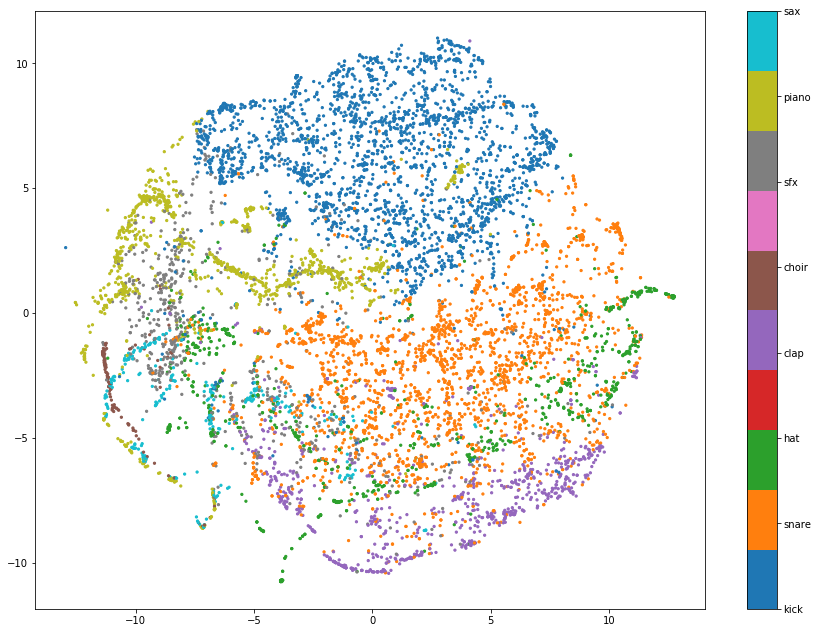

In [32]:
print(tsne_results.shape)
fig1 = plt.figure(figsize=(15, 11))
ax1 = fig1.add_subplot(111)
ax = ax1.scatter(tsne_results[:,0], tsne_results[:,1], cmap='tab10', marker = '.', c = np.array(emb_cats), alpha = 1.0, s=20)
# cbar= plt.colorbar(ax1)
# cbar.set_label("elevation (m)", labelpad=+1)
# ax=plt.gca() #get the current axes
# PCM=ax.get_children()[2] #get the mappable, the 1st and the 2nd are the x and y axes
cb = plt.colorbar(ax) 
# loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(np.arange(0,len(categories)+1))
cb.set_ticklabels([c[0] for c in categories]+['None'])
plt.show()

/Users/maxfrenzel/py3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


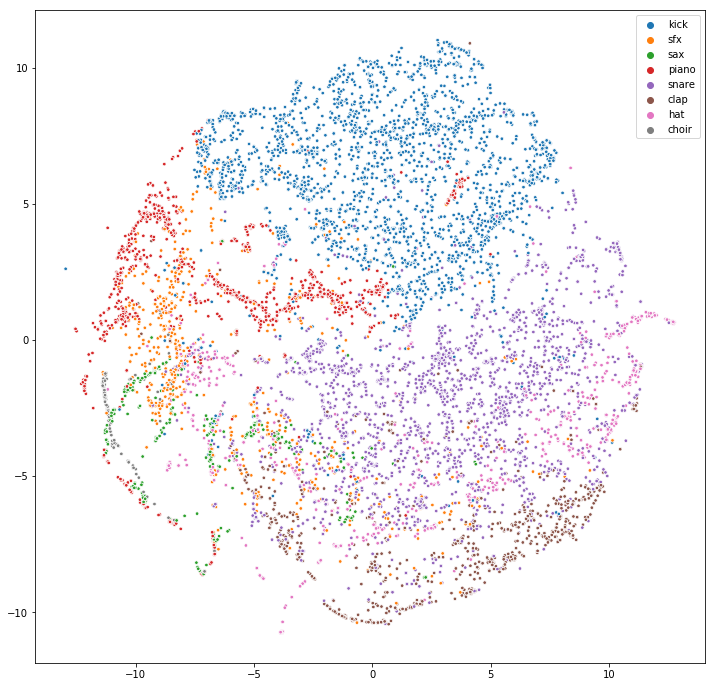

In [63]:
import seaborn as sns
plt.figure(figsize=(12, 12))
fig1.add_subplot(111)
# cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], hue=emb_cat_names, s=50, marker=".")

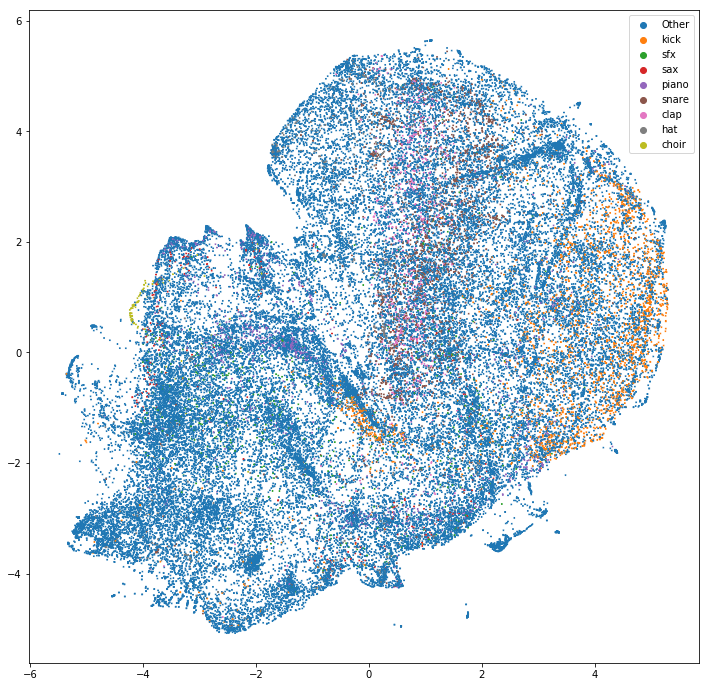

In [14]:
import seaborn as sns
fig1 = plt.figure(figsize=(12, 12))
fig1.add_subplot(111)
# cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], hue=emb_cat_names, s=2, marker="x")

In [10]:
import shlex, subprocess

# Generate a bunch of random files using the generate.py script
num_to_generate = 200
for k in range(1000,1001):
    
    # How many files to combine?
    num_in = np.random.randint(1,4)
    
    #Pick random files
    files_in = []
    for j in range(num_in):
        files_in.append(random.choice(audio_files))
        
    dir_arg = ''
    for file in files_in:
        dir_arg += f'"{file}" '
        
    command_line = f"python generate.py --logdir='iaf5_64d_2' --file_in {dir_arg} --file_out random{k}"
    
    args = shlex.split(command_line)        
    subprocess.call(args)

In [11]:
import shlex, subprocess

# Generate a bunch of random files, based on latent space sampling, using the generate.py script
for k in range(1000):
        
    command_line = f"python generate.py --logdir='iaf5_64d_2' --file_in  --file_out sampled{k}"
    
    args = shlex.split(command_line)        
    subprocess.call(args)

KeyboardInterrupt: 